# Warm up
### 1abc)

In [32]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [33]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [34]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [35]:
import torch
from torch.nn import Linear
from torch.nn import Dropout
import torch.nn.functional as F


class MLP(torch.nn.Module):
    '''
    input_features: features of dataset
    output_dim: classes of dataset
    width: How many hidden neurons in each layer
    '''
    def __init__(self,
                 input_features,
                 width, output_dim):
        super().__init__()
        self.fc_1 = Linear(input_features, width)
        self.fc_2 = Linear(width, width)
        self.drop = Dropout(p=0.5)
        self.fc_3 = Linear(width, output_dim)
        
    def forward(self, x):
        x = x.flatten(1, -1)
        x = self.fc_1(x)
        x = torch.relu(x)
        x = self.fc_2(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.fc_3(x)
        return x

input_features = dataset.num_node_features
width = int(2*dataset.num_node_features/3)
output_dim = dataset.num_classes
model = MLP(input_features, width, output_dim)
print(model)

MLP(
  (fc_1): Linear(in_features=1433, out_features=955, bias=True)
  (fc_2): Linear(in_features=955, out_features=955, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc_3): Linear(in_features=955, out_features=7, bias=True)
)


In [38]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

best_test_acc = 0.0
num_epochs_without_improvement = 0
patience = 30  # Number of epochs to wait before stopping if there is no improvement.
for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        out = model(data.x)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
        
    if val_acc > best_test_acc:
        best_test_acc = val_acc
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1
    
    if num_epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch} epochs. Best validation accuracy: {best_test_acc:.4f}')
        best_model_params_dense = model.state_dict()
        break
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
model.eval()
with torch.no_grad():
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 0.0235, Validation Accuracy: 0.3420
Epoch: 002, Loss: 2.8807, Validation Accuracy: 0.3400
Epoch: 003, Loss: 0.4055, Validation Accuracy: 0.3840
Epoch: 004, Loss: 0.5016, Validation Accuracy: 0.3420
Epoch: 005, Loss: 0.7106, Validation Accuracy: 0.4120
Epoch: 006, Loss: 0.1558, Validation Accuracy: 0.4620
Epoch: 007, Loss: 0.0334, Validation Accuracy: 0.4680
Epoch: 008, Loss: 0.0183, Validation Accuracy: 0.4720
Epoch: 009, Loss: 0.0216, Validation Accuracy: 0.5420
Epoch: 010, Loss: 0.0198, Validation Accuracy: 0.5900
Epoch: 011, Loss: 0.0239, Validation Accuracy: 0.6140
Epoch: 012, Loss: 0.0126, Validation Accuracy: 0.6060
Epoch: 013, Loss: 0.0073, Validation Accuracy: 0.5720
Epoch: 014, Loss: 0.0056, Validation Accuracy: 0.5760
Epoch: 015, Loss: 0.0045, Validation Accuracy: 0.5440
Epoch: 016, Loss: 0.0065, Validation Accuracy: 0.5260
Epoch: 017, Loss: 0.0078, Validation Accuracy: 0.5460
Epoch: 018, Loss: 0.0063, Validation Accuracy: 0.5800
Epoch: 019, Loss: 0.0072, Va

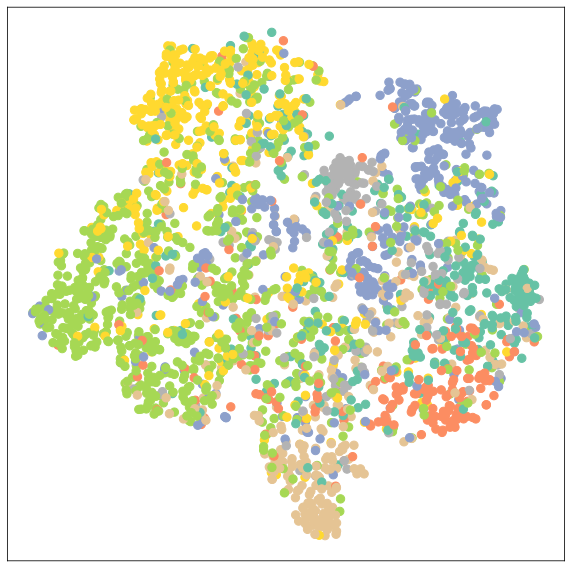

In [39]:
model = MLP(input_features, width, output_dim)
model.load_state_dict(best_model_params_dense)
out = model(data.x)
visualize(out, color=data.y)

In [40]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    '''
    input_features: features of dataset
    output_dim: classes of dataset
    width: How many hidden neurons in each layer
    '''
    def __init__(self,
                 input_features,
                 width, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_features, width)
        self.dropout = Dropout(p=0.5)
        self.conv2 = GCNConv(width, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)

        return x

In [41]:
# Model
input_features = dataset.num_node_features
width = int(2*dataset.num_node_features/3)
output_dim = dataset.num_classes
model = GCN(input_features, width, output_dim)


# Optimizer
lr = 0.01
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()


best_test_acc = 0.0
num_epochs_without_improvement = 0
patience = 60  # Number of epochs to wait before stopping if there is no improvement.
for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
        
    if val_acc > best_test_acc:
        best_test_acc = val_acc
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1
    
    if num_epochs_without_improvement >= patience:
        print(f'Early stopping after {epoch} epochs. Best validation accuracy: {best_test_acc:.4f}')
        best_model_params_dense = model.state_dict()
        break
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9459, Validation Accuracy: 0.4140
Epoch: 002, Loss: 1.9080, Validation Accuracy: 0.3300
Epoch: 003, Loss: 1.8584, Validation Accuracy: 0.3820
Epoch: 004, Loss: 1.7918, Validation Accuracy: 0.5320
Epoch: 005, Loss: 1.7108, Validation Accuracy: 0.6800
Epoch: 006, Loss: 1.6120, Validation Accuracy: 0.7380
Epoch: 007, Loss: 1.4994, Validation Accuracy: 0.7600
Epoch: 008, Loss: 1.3766, Validation Accuracy: 0.7800
Epoch: 009, Loss: 1.2467, Validation Accuracy: 0.7840
Epoch: 010, Loss: 1.1108, Validation Accuracy: 0.7860
Epoch: 011, Loss: 0.9793, Validation Accuracy: 0.7820
Epoch: 012, Loss: 0.8698, Validation Accuracy: 0.7900
Epoch: 013, Loss: 0.7477, Validation Accuracy: 0.7880
Epoch: 014, Loss: 0.6534, Validation Accuracy: 0.7960
Epoch: 015, Loss: 0.5707, Validation Accuracy: 0.7960
Epoch: 016, Loss: 0.4913, Validation Accuracy: 0.8040
Epoch: 017, Loss: 0.4440, Validation Accuracy: 0.8020
Epoch: 018, Loss: 0.3925, Validation Accuracy: 0.8020
Epoch: 019, Loss: 0.3659, Va

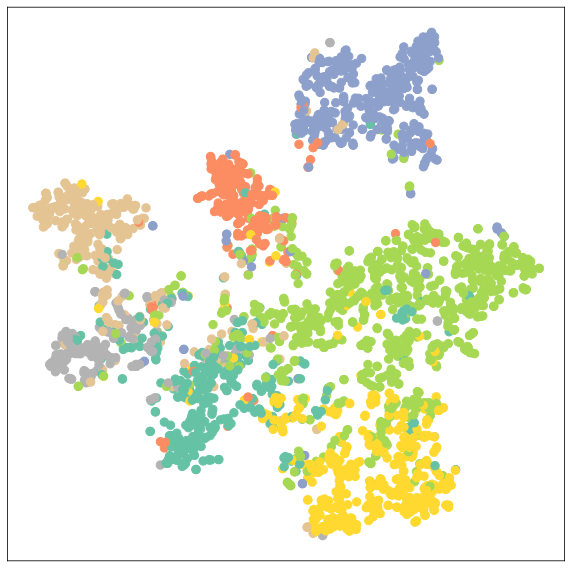

In [42]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# Decoding a quantum memory
### The task will be to train a network for graph classification.
- Design a graph neural network with the objective to optimize the accuracy on the
test set. You should be able to get a test accuracy of at least 95%, possibly up to
98%.
- Plot training and test accuracy over at least 10 epochs of training.
- Be ready to discuss your code and the components of your network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm2d, BatchNorm1d, Dropout
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv, global_max_pool, SAGEConv

%config InlineBackend.figure_format = 'svg'

In [2]:
dataset = torch.load('graph_data_decoding_2023.pt')

#### Note that the label y, is given by a tensor with 2 elements, giving a binary representation of the predicted equivalence class.  

#### *   00 <-> class I
#### *   10 <-> class X
#### *   01 <-> class Z
#### *   11 <-> class Y

#### The loss can either be constructed using two spearate classifiers, one for X and one for Z, or combined into one over all four classes. Either should work.



In [3]:
# split the dataset into test and validation:
num_samples = len(dataset)
train_data = dataset[int(.95 * num_samples ) :] # 95% train
test_data = dataset[: int(.05 * num_samples )] # 5% test
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

In [13]:
# GNN Architecture
class GNN(torch.nn.Module):
    '''
    input_features: features of dataset
    output_dim: classes of dataset
    width: How many hidden neurons in each layer
    '''
    def __init__(self,
                 input_features,
                 width, output_dim):
        super().__init__()
        self.nheads = 2
        self.conv1 = GCNConv(input_features, 2 * width)
        self.bnorm1 = BatchNorm1d(2*width)
        self.conv2 = GATConv(2 * width, width*2, heads=self.nheads, concat=True, dropout=0.6)
        self.conv3 = GCNConv(2*width*self.nheads, 2 * width)
        self.bnorm2 = BatchNorm1d(2*width)
        self.conv4 = GraphConv(2 * width, 2 * width)
        self.conv5 = GCNConv(2 * width, 2 * width)
        self.dropout1 = Dropout(p=0.65)
        self.lin1 = Linear(width*self.nheads, width)
        self.dropout2 = Dropout(p=0.65)
        self.lin2 = Linear(width, output_dim)

    def forward(self, x, edge_index, batch, edge_attribute):
        x = self.conv1(x, edge_index, edge_weight=edge_attribute)
        x = self.bnorm1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index, edge_weight=edge_attribute)
        x = self.bnorm2(x)
        x = F.relu(x)

        x = self.conv4(x, edge_index, edge_weight=edge_attribute)
        x = F.relu(x)

        x = self.conv5(x, edge_index, edge_weight=edge_attribute)
        x = F.relu(x)


        x = global_mean_pool(x, batch)

        x = self.dropout1(x)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        x = self.lin2(x)

        return x


In [14]:
# Model
input_features = dataset[0].x.size(1)
width = 44 #BEST 44
output_dim = dataset[0].y.size(1)
model = GNN(input_features, width, output_dim)
print(model)

# Optimizer
lr = 0.01
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# Use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=5)


def train():
    model.train()
    
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch, data.edge_attr)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss


def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        label = data.y
        label_X = label[:,0]
        label_Z = label[:,1]
        
        out = model(data.x, data.edge_index, data.batch, data.edge_attr)  
        pred = (torch.sgn(out) +1)/2     # Use 0/1
        
        for i in range(len(pred)):
            if pred[i,0] == label_X[i] and pred[i,1] == label_Z[i]:
                correct += 1
                continue
            if pred[i,0] == label_X[i] or pred[i,1] == label_Z[i]:
                correct += 1
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_list = []
test_list = []

# Early stopping
early_stop_patience = 20
best_test_acc = 0
stop_counter = 0
nEpochs = 100
for epoch in range(nEpochs):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_list.append(train_acc)
    test_list.append(test_acc)
    
    scheduler.step(test_acc)  # Update learning rate based on test accuracy
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        stop_counter = 0
    else:
        stop_counter += 1
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Patience Counter: {stop_counter}')

    if stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        print(f'Best accuracy: {best_test_acc:.4f}')
        break

GNN(
  (conv1): GCNConv(4, 88)
  (bnorm1): BatchNorm1d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(88, 88, heads=2)
  (conv3): GCNConv(176, 88)
  (bnorm2): BatchNorm1d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GraphConv(88, 88)
  (conv5): GCNConv(88, 88)
  (dropout1): Dropout(p=0.65, inplace=False)
  (lin1): Linear(in_features=88, out_features=44, bias=True)
  (dropout2): Dropout(p=0.65, inplace=False)
  (lin2): Linear(in_features=44, out_features=2, bias=True)
)
Epoch: 001, Train Loss: 0.1334, Train Acc: 0.9601, Test Acc: 0.9623, Patience Counter: 0
Epoch: 002, Train Loss: 0.1573, Train Acc: 0.9808, Test Acc: 0.9810, Patience Counter: 0
Epoch: 003, Train Loss: 0.1304, Train Acc: 0.9787, Test Acc: 0.9794, Patience Counter: 1
Epoch: 004, Train Loss: 0.1639, Train Acc: 0.9851, Test Acc: 0.9851, Patience Counter: 0
Epoch: 005, Train Loss: 0.1448, Train Acc: 0.9744, Test Acc: 0.9740, Patience Counter: 1
Epoch: 

Epoch: 087, Train Loss: 0.1291, Train Acc: 0.9819, Test Acc: 0.9830, Patience Counter: 2
Epoch: 088, Train Loss: 0.1032, Train Acc: 0.9816, Test Acc: 0.9828, Patience Counter: 3
Epoch: 089, Train Loss: 0.1165, Train Acc: 0.9819, Test Acc: 0.9830, Patience Counter: 4
Epoch: 090, Train Loss: 0.1217, Train Acc: 0.9820, Test Acc: 0.9831, Patience Counter: 5
Epoch: 091, Train Loss: 0.1012, Train Acc: 0.9678, Test Acc: 0.9697, Patience Counter: 6
Epoch: 092, Train Loss: 0.0899, Train Acc: 0.9891, Test Acc: 0.9892, Patience Counter: 7
Epoch: 093, Train Loss: 0.1262, Train Acc: 0.9674, Test Acc: 0.9691, Patience Counter: 8
Epoch: 094, Train Loss: 0.1321, Train Acc: 0.9678, Test Acc: 0.9691, Patience Counter: 9
Epoch: 095, Train Loss: 0.1246, Train Acc: 0.9892, Test Acc: 0.9892, Patience Counter: 10
Epoch: 096, Train Loss: 0.1174, Train Acc: 0.9893, Test Acc: 0.9895, Patience Counter: 0
Epoch: 097, Train Loss: 0.1141, Train Acc: 0.9819, Test Acc: 0.9830, Patience Counter: 1
Epoch: 098, Train Lo

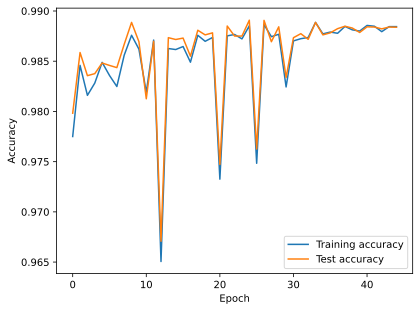

Best accuracy: 0.9891


In [6]:
plt.plot(train_list, label='Training accuracy')
plt.plot(test_list, label='Test accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
print(f'Best accuracy: {best_test_acc:.4f}')